In [1]:
!pip install category_encoders --quiet


In [2]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns  # data visualization
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
#  Interactive dashboard
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
# for imputing missing values 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

## Import data
let's now try to import our data

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # drop the data with the high null count
    df.drop(columns=["floor","expenses"],inplace=True)

   # drop a columns with a high and low cardinality
    df.drop(columns=["operation","property_type","properati_url","currency"],inplace=True)
    # drop a column with a leaky features
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2',
    ],
           inplace=True
           )
    # drop the columns with multicolinearity
    df.drop(columns=[
        'rooms',
        'surface_total_in_m2'],
           inplace=True
           )
    return df

In [4]:
files=glob(r"C:\Users\educa\Downloads\Buenos data\buenos-aires-real-estate-*.csv")
files

['C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-5.csv']

The last time we put all our DataFrames into a list, we used a for loop. This time, we're going to use a more compact coding technique called **list comprehension**

In [5]:
frames=[wrangle(file) for  file in files]
frames[0]

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.00,70.0,-34.584651,-58.454693,Chacarita
9,87000.00,42.0,-34.638979,-58.500115,Villa Luro
29,118000.00,54.0,-34.615847,-58.459957,Caballito
40,57000.00,42.0,-34.625222,-58.382382,Constitución
41,90000.00,50.0,-34.610610,-58.412511,Once
...,...,...,...,...,...
8589,73536.95,42.0,-34.631591,-58.370191,Barracas
8590,119000.00,41.0,-34.604555,-58.418206,Almagro
8593,62000.00,43.0,-34.624002,-58.390588,Barracas
8601,125000.00,70.0,-34.601455,-58.378132,San Nicolás


In [6]:
df=pd.concat(frames,ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


## Identify and drop null values

 Modify your wrangle function to drop any columns that are more than half NaN values. Be sure to rerun all the cells above before you continue.

## Low and High Cardinality Features 
he next thing we need to look out for are categorical columns with low or high cardinality. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.


In [7]:
df.select_dtypes('object').nunique()

neighborhood    57
dtype: int64

It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

## Leakage
It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

In [8]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

## Multicollinearity
Finally, the last issue we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

Modify your wrangle function to remove columns so that there are no strongly correlated features in your feature matrix.

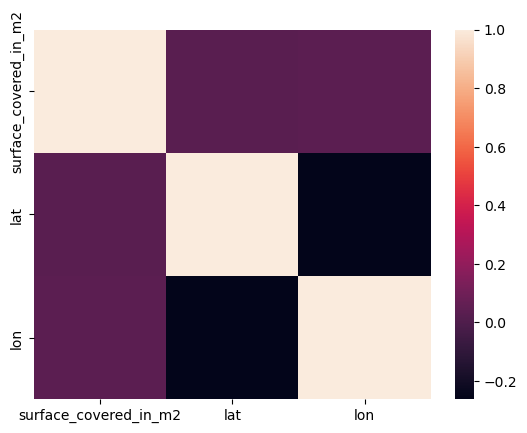

In [9]:
corr=df.select_dtypes('number').drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

df.info()

### split data

In [10]:
target = "price_aprox_usd"
features=["surface_covered_in_m2","lat", "lon","neighborhood"]
X_train=df[features]
y_train=df[target]

# Build Model

## Baseline

In [11]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)
print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


## Iterate

In [12]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


## Evaluate

In [13]:
y_pred_training= model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 24207.107190330174


# Communicate Results

For this lesson, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model — in other words, use it in action. So let's look at two ways you might deploy this model. 

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output. 

In [14]:
def make_prediction(Area,lat,lon,neighborhood):
    data={
        "surface_covered_in_m2":Area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df=pd.DataFrame(data,index=[0])
    prediction=model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [15]:
make_prediction(150, -34.60, -58.46, "Puerto Madero")

'Predicted apartment price: $452858.85'

In [24]:
interact(
    make_prediction,
    Area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='Area', max=101, min=30), FloatSlider(value=-34.59890626…